In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [80]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [81]:
train['month'], temp , train['year'] = train['id'].str.split('/').str
train['year'] = train['year'].astype(int)
train['month'] = train['month'].astype(int)
train['y_m'] = train['year'] + train['month']/13
train_s = train.sort_values('y_m')

In [82]:
test['month'], temp , test['year'] = test['id'].str.split('/').str
test['year'] = test['year'].astype(int)
test['month'] = test['month'].astype(int)
test['y_m'] = test['year'] + test['month']/13
test_s = test.sort_values('y_m')

Text(0, 0.5, 'Value')

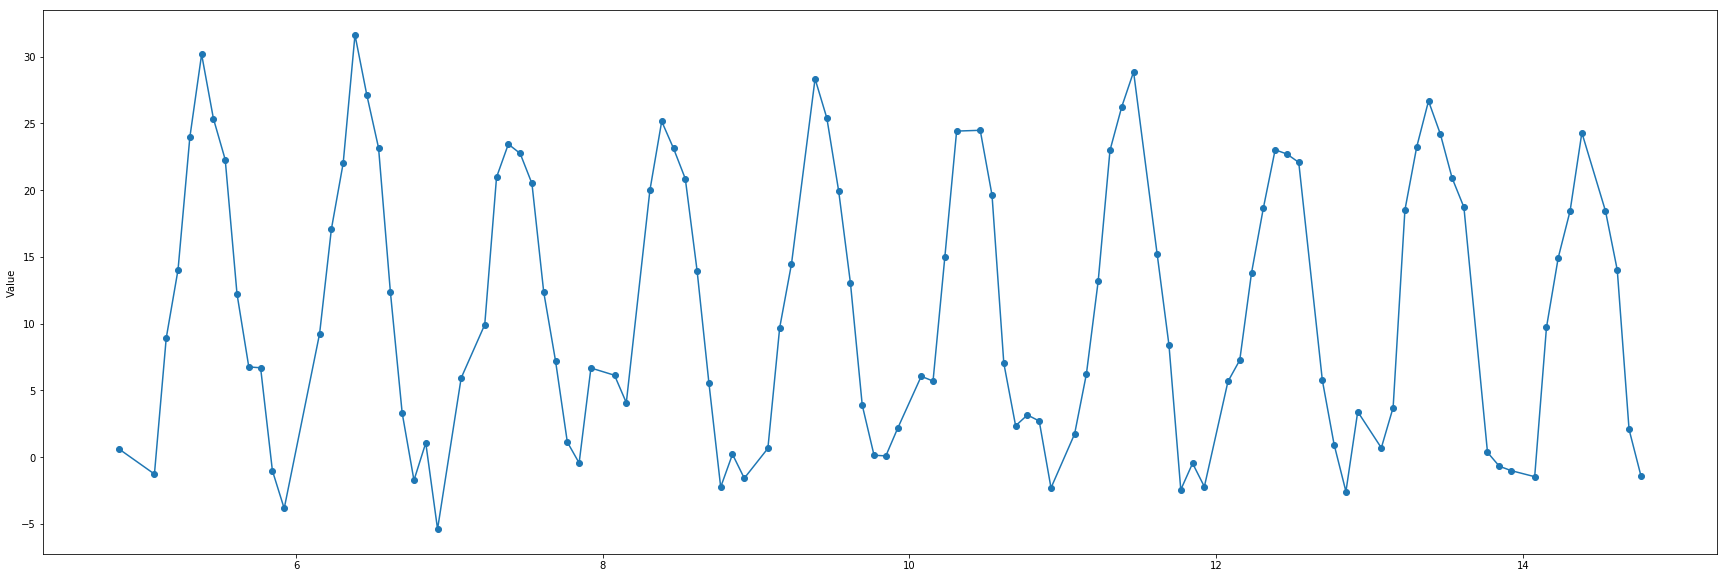

In [83]:
plt.figure(figsize=(30,10))
plt.plot(train_s['y_m'],train_s['value'],'-o')
plt.ylabel('Value')
#plt.savefig('p2/data.png')

In [84]:
def moore_penrose(phi,lambd=0):
    temp = np.linalg.inv(lambd*np.identity(phi.shape[1]) + np.dot(phi.T, phi))
    mpi = np.dot(temp, phi.T)
    return mpi

In [85]:
mths = np.array(train['month'])
yrs = np.array(train['year'])    
vals = np.array(train['value'])
means = dict()
var = dict()
var_mu = 1e-3
mean_mu = 5.3
for y in set(yrs):
    ind = [i for i, j in enumerate(yrs) if j == y]
    temp = [mths[i] for i in ind]
    var[y] = 9.75
    means[y] = (var_mu*sum(temp)+var[y]*mean_mu)/(var_mu*len(temp)+var[y])

In [86]:
def make_design_matrix(n,m,months,years,mu=means,s=var):
    dm = np.zeros((n,m))
    for i in range(n):
        dm[i,0] = 1
        dm[i,1] = np.exp(-1*(months[i]-mu[years[i]])**2/(2*s[years[i]]))
        for j in range(2,m,2):
            dm[i,j] = np.sin(months[i]*np.pi/(3*j))
        for j in range(3,m,2):
            dm[i,j] = np.cos(months[i]*np.pi/(3*(j-1)))
            
    return dm

In [87]:
t = np.array(train['value'])
t = t.reshape((len(t),1))

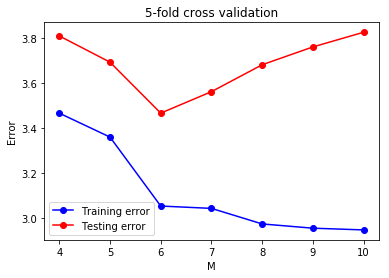

In [88]:
# 5 fold cross validation for M

data_shuffled = np.concatenate([np.array(train['month']).reshape(110,1), np.array(train['year']).reshape(110,1), t], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
for i in range(4,11):
    tr_e = 0
    te_e = 0
    for j in range(5):
        tr = np.concatenate([data_shuffled[:j*22], data_shuffled[(j+1)*22:]])
        te = data_shuffled[j*22 : (j+1)*22]
        x_train = tr[:,0:2]
        t_train = tr[:,2]
        x_test = te[:,0:2]
        t_test = te[:,2]
        
        design_matrix_train = make_design_matrix(88,i,x_train[:,0],x_train[:,1])
        design_matrix_test = make_design_matrix(22,i,x_test[:,0],x_test[:,1])
        
        w_mp = np.dot(moore_penrose(design_matrix_train), t_train)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += (0.5 * (np.sum(np.square(y_mp_train - t_train)))) / 88
        te_e += (0.5 * (np.sum(np.square(y_mp_test - t_test)))) / 22
        #print(design_matrix_test.shape)
        
    train_err.append(tr_e/5)
    test_err.append(te_e/5)

xa = np.arange(4,11)
plt.figure()
plt.plot(xa,train_err,'-ob', label = "Training error")
plt.plot(xa,test_err,'-or', label = "Testing error")
plt.xlabel('M')
plt.ylabel('Error')
plt.title('5-fold cross validation')
plt.legend()
plt.savefig('p2/M.png')


In [89]:
M = 6

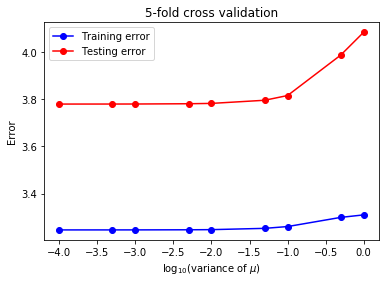

In [90]:
data_shuffled = np.concatenate([np.array(train['month']).reshape(110,1), np.array(train['year']).reshape(110,1), t], axis = 1)
np.random.shuffle(data_shuffled)

train_err = []
test_err = []
mu_var_priors = [1,5e-1,1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4]
for i in mu_var_priors:
    tr_e = 0
    te_e = 0
    for j in range(5):
        
        mths = np.array(train['month'])
        yrs = np.array(train['year'])
        means = dict()
        var = dict()
        var_mu = i
        mean_mu = 5.3
        for y in yrs:
            ind = [i for i, j in enumerate(yrs) if j == y]
            temp = [mths[i] for i in ind]
            var[y] = np.var(temp)*(len(temp)-1)/len(temp)
            if var[y] == 0:
                var[y] = 11
            means[y] = (var_mu*sum(temp)+var[y]*mean_mu)/(var_mu*len(temp)+var[y])
        tr = np.concatenate([data_shuffled[:j*22], data_shuffled[(j+1)*22:]])
        te = data_shuffled[j*22 : (j+1)*22]
        x_train = tr[:,0:2]
        t_train = tr[:,2]
        x_test = te[:,0:2]
        t_test = te[:,2]
        
        design_matrix_train = make_design_matrix(88,M,x_train[:,0],x_train[:,1],means,var)
        design_matrix_test = make_design_matrix(22,M,x_test[:,0],x_test[:,1],means,var)
        w_mp = np.dot(moore_penrose(design_matrix_train), t_train)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += (0.5 * (np.sum(np.square(y_mp_train - t_train)))) / 88
        te_e += (0.5 * (np.sum(np.square(y_mp_test - t_test)))) / 22
        #print(design_matrix_test.shape)
        
    train_err.append(tr_e/5)
    test_err.append(te_e/5)

xa = np.log10(mu_var_priors)
plt.figure()
plt.plot(xa,train_err,'-ob', label = "Training error")
plt.plot(xa,test_err,'-or', label = "Testing error")
plt.xlabel('log$_{10}$(variance of $\mu$)')
plt.ylabel('Error')
plt.title('5-fold cross validation')
plt.legend()
plt.savefig('p2/mu_var_prior.png')

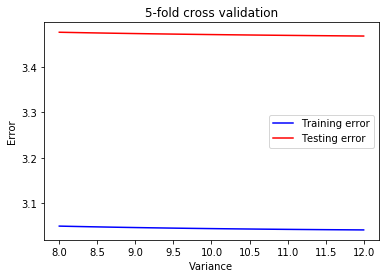

In [91]:
data_shuffled = np.concatenate([np.array(train['month']).reshape(110,1), np.array(train['year']).reshape(110,1), t], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
var_priors = np.linspace(8,12,40)
for i in var_priors:
    tr_e = 0
    te_e = 0
    for j in range(5):
        
        mths = np.array(train['month'])
        yrs = np.array(train['year'])
        means = dict()
        var = dict()
        var_mu = 1e-3
        mean_mu = 5.5
        for y in yrs:
            ind = [i for i, j in enumerate(yrs) if j == y]
            temp = [mths[i] for i in ind]
            var[y] = i
            means[y] = (var_mu*sum(temp)+var[y]*mean_mu)/(var_mu*len(temp)+var[y])
        tr = np.concatenate([data_shuffled[:j*22], data_shuffled[(j+1)*22:]])
        te = data_shuffled[j*22 : (j+1)*22]
        x_train = tr[:,0:2]
        t_train = tr[:,2]
        x_test = te[:,0:2]
        t_test = te[:,2]
        
        design_matrix_train = make_design_matrix(88,M,x_train[:,0],x_train[:,1],means,var)
        design_matrix_test = make_design_matrix(22,M,x_test[:,0],x_test[:,1],means,var)
        w_mp = np.dot(moore_penrose(design_matrix_train), t_train)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += (0.5 * (np.sum(np.square(y_mp_train - t_train)))) / 88
        te_e += (0.5 * (np.sum(np.square(y_mp_test - t_test)))) / 22
        
    train_err.append(tr_e/5)
    test_err.append(te_e/5)

xa = var_priors
plt.figure()
plt.plot(xa,train_err,'b', label = "Training error")
plt.plot(xa,test_err,'r', label = "Testing error")
plt.xlabel('Variance')
plt.ylabel('Error')
plt.title('5-fold cross validation')
plt.legend()
plt.savefig('p2/s.png')

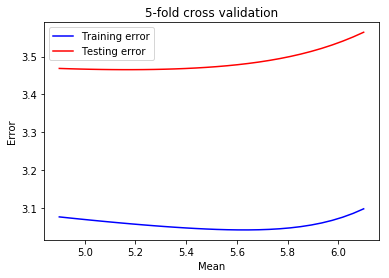

In [92]:
data_shuffled = np.concatenate([np.array(train['month']).reshape(110,1), np.array(train['year']).reshape(110,1), t], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
mu_priors = np.linspace(4.9,6.1,30)
for i in mu_priors:
    tr_e = 0
    te_e = 0
    for j in range(5):
        
        mths = np.array(train['month'])
        yrs = np.array(train['year'])
        means = dict()
        var = dict()
        var_mu = 1e-3
        mean_mu = i
        for y in yrs:
            ind = [i for i, j in enumerate(yrs) if j == y]
            temp = [mths[i] for i in ind]
            var[y] = 9.75
            means[y] = (var_mu*sum(temp)+var[y]*mean_mu)/(var_mu*len(temp)+var[y])
        tr = np.concatenate([data_shuffled[:j*22], data_shuffled[(j+1)*22:]])
        te = data_shuffled[j*22 : (j+1)*22]
        x_train = tr[:,0:2]
        t_train = tr[:,2]
        x_test = te[:,0:2]
        t_test = te[:,2]
        
        design_matrix_train = make_design_matrix(88,M,x_train[:,0],x_train[:,1],means,var)
        design_matrix_test = make_design_matrix(22,M,x_test[:,0],x_test[:,1],means,var)
        w_mp = np.dot(moore_penrose(design_matrix_train), t_train)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += (0.5 * (np.sum(np.square(y_mp_train - t_train)))) / 88
        te_e += (0.5 * (np.sum(np.square(y_mp_test - t_test)))) / 22
        
        
    train_err.append(tr_e/5)
    test_err.append(te_e/5)

xa = mu_priors
plt.figure()
plt.plot(xa,train_err,'b', label = "Training error")
plt.plot(xa,test_err,'r', label = "Testing error")
plt.xlabel('Mean')
plt.ylabel('Error')
plt.title('5-fold cross validation')
plt.legend()
plt.savefig('p2/mu_prior.png')


In [93]:
shuffled_tr = train.sample(frac=1)
val_data = shuffled_tr.iloc[110:]
train_data = shuffled_tr.iloc[:110]

In [94]:
N = train_data.shape[0]
M = 6
design_matrix = make_design_matrix(N, M, np.array(train_data['month']), np.array(train_data['year']))
design_matrix_val = make_design_matrix(val_data.shape[0], M, np.array(val_data['month']), np.array(val_data['year']))
t_train = np.array(train_data['value'])
t_train = t_train.reshape((len(t_train),1))
t_val = np.array(val_data['value'])
t_val = t_val.reshape((len(t_val),1))
t = np.array(train['value'])
t = t.reshape((len(t),1))

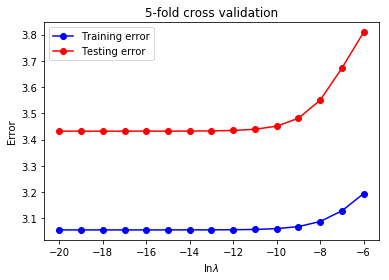

In [95]:
# 5 fold cross validation for lambda

data_shuffled = np.concatenate([np.array(train['month']).reshape(110,1), np.array(train['year']).reshape(110,1), t], axis = 1)
np.random.shuffle(data_shuffled)

train_err = []
test_err = []
lambdas = np.exp(np.arange(-20,-5))
for lambd in lambdas:
    tr_e = 0
    te_e = 0
    for j in range(5):
        tr = np.concatenate([data_shuffled[:j*22], data_shuffled[(j+1)*22:]])
        te = data_shuffled[j*22 : (j+1)*22]
        x_train = tr[:,0:2]
        t_tr = tr[:,2]
        x_test = te[:,0:2]
        t_te = te[:,2]
        
        design_matrix_train = make_design_matrix(88,M,x_train[:,0],x_train[:,1])
        
        design_matrix_test = make_design_matrix(22,M,x_test[:,0],x_test[:,1])
        w_mp = np.dot(moore_penrose(design_matrix_train,lambd), t_tr)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += (0.5 * (np.sum(np.square(y_mp_train - t_tr))) + lambd/2 * np.sum(np.square(w_mp))) / 88
        te_e += (0.5 * (np.sum(np.square(y_mp_test - t_te))) + lambd/2 * np.sum(np.square(w_mp))) / 22
        #print(design_matrix_test.shape)
        
    train_err.append(tr_e/5)
    test_err.append(te_e/5)

xa = np.log(lambdas)
plt.figure()
plt.plot(xa,train_err,'-ob', label = "Training error")
plt.plot(xa,test_err,'-or', label = "Testing error")
plt.xlabel('ln$\lambda$')
plt.ylabel('Error')
plt.title('5-fold cross validation')
plt.legend()
plt.savefig('p2/lambda.png')


In [96]:
data_shuffled = np.concatenate([np.array(train['month']).reshape(110,1), np.array(train['year']).reshape(110,1), t], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
lambd = 0
min_err = np.inf
w = np.zeros((M,1))
for j in range(5):
    tr = np.concatenate([data_shuffled[:j*22], data_shuffled[(j+1)*22:]])
    te = data_shuffled[j*22 : (j+1)*22]
    x_train = tr[:,0:2]
    t_tr = tr[:,2]
    x_test = te[:,0:2]
    t_test = te[:,2]
    t_tr = t_tr.reshape((len(t_tr),1))
    t_test = t_test.reshape((len(t_test),1))

    design_matrix_train = make_design_matrix(88,M,x_train[:,0],x_train[:,1])

    design_matrix_test = make_design_matrix(22,M,x_test[:,0],x_test[:,1])
    
    w_mp = np.dot(moore_penrose(design_matrix_train,lambd), t_tr)
    y_mp_train = np.dot(design_matrix_train,w_mp)
    y_mp_test = np.dot(design_matrix_test,w_mp)
    tr_e = (0.5 * (np.sum(np.square(y_mp_train - t_tr)))) / 88
    te_e = (0.5 * (np.sum(np.square(y_mp_test - t_test)))) / 22

    if te_e < min_err:
        w = w_mp
        min_err = te_e
    
#print(0.5 * (np.sum(np.square(np.dot(design_matrix_val,w) - t_val)))/ len(t_val))

In [97]:
print(0.5 * (np.sum(np.square(np.dot(design_matrix,w) - t_train)))/ len(t_train))

3.101085193888082


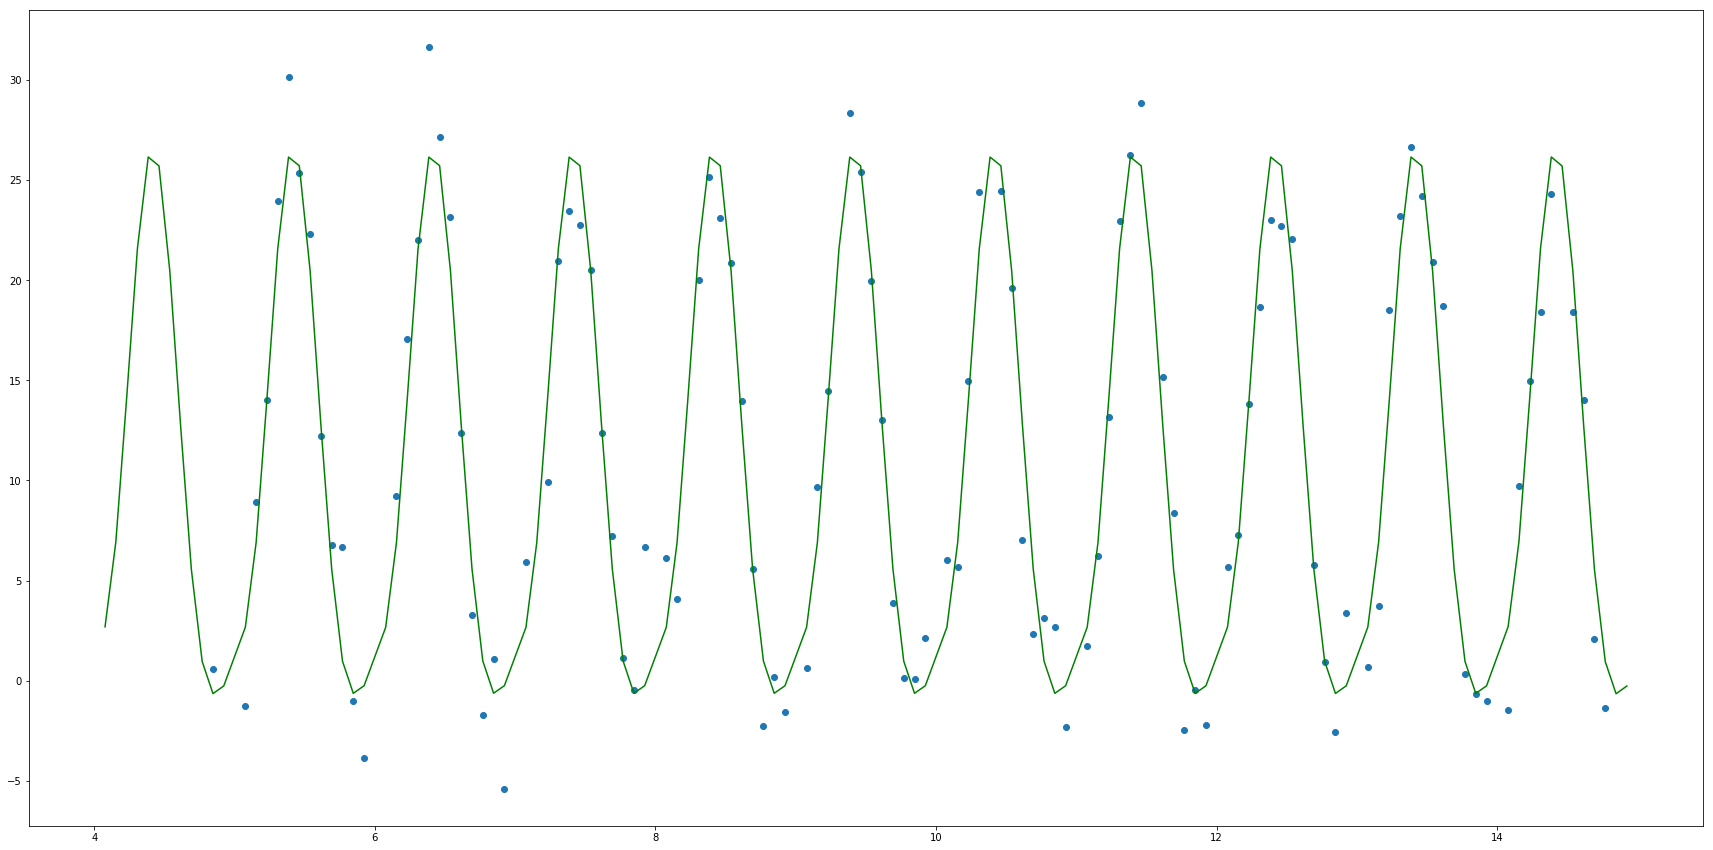

In [98]:
x = []
y = []
d = dict()
for i in range(4,15):
    for j in range(1,13):
            temp = make_design_matrix(1,M,np.array([j]),np.array([i]))
            y.append(np.dot(temp, w)[0,0])
            x.append(i+j/13)

plt.figure(figsize=(30,15))
plt.plot(train_s['y_m'],train_s['value'],'o')
plt.plot(x,y,'g')

In [99]:
test_months = np.array(test_s['month'])
test_years = np.array(test_s['year'])
dm_test = make_design_matrix(test_s.shape[0],M,test_months,test_years)    
pred = np.dot(dm_test,w)
test_s['value'] = pred

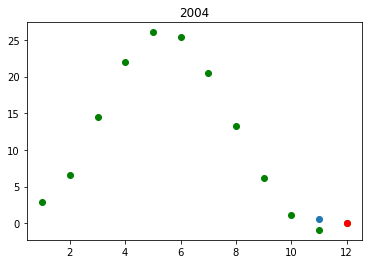

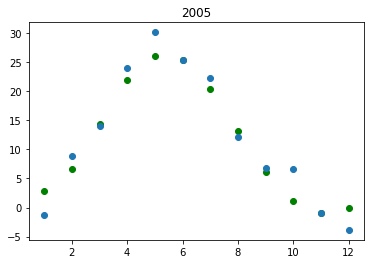

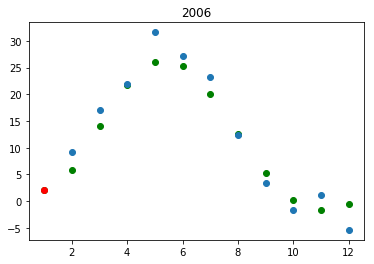

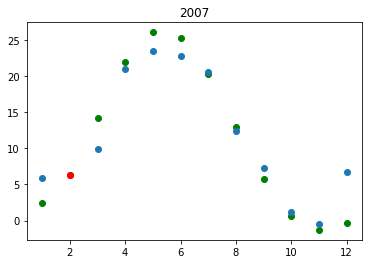

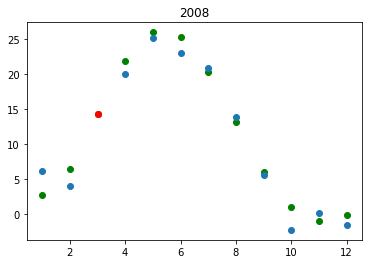

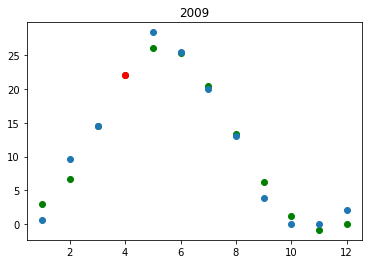

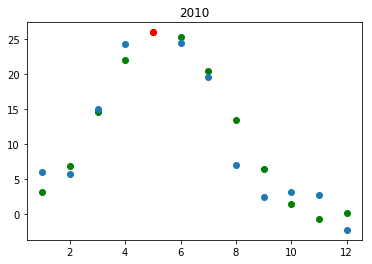

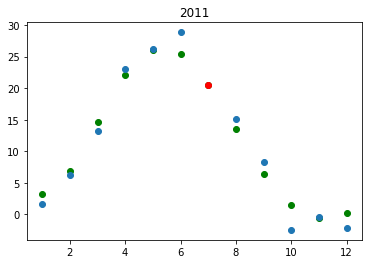

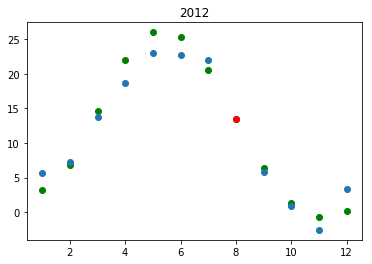

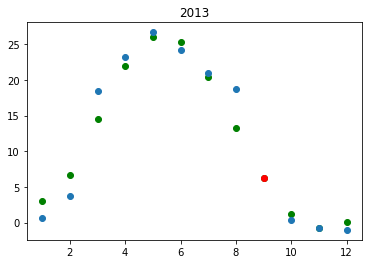

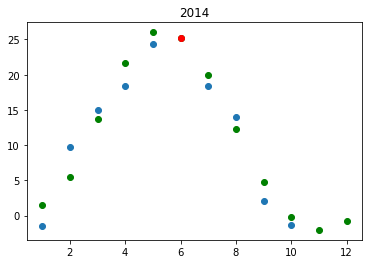

In [67]:
#plt.figure(figsize=(10,40))
for i in range(4,15):
    #plt.subplot(11,1,i-3)
    plt.figure()
    plt.title(2000+i)
    plt.plot(np.arange(1,13),y[(i-4)*12:(i-3)*12],'og')
    p2 = train_s[train_s['year']==i]
    p3 = test_s[test_s['year']==i]
    plt.plot(p2['month'],p2['value'],'o')
    plt.plot(p3['month'],p3['value'],'or')
    #plt.savefig('p2/'+str(i)+'.png')

In [73]:
submit = test_s[['id','value']]
submit = submit.sort_index()
#submit.to_csv('submission.csv',index=False)
#print(submit)
submit

,id,value
0,5/1/10,26.036882
1,4/1/09,22.009747
2,9/1/13,6.245866
3,1/1/06,2.048368
4,2/1/07,6.235162
5,8/1/12,13.419941
6,6/1/14,25.200759
7,3/1/08,14.404839
8,12/1/04,-0.028271
9,7/1/11,20.540858
